In [ ]:
# @title foo
#!pip install transformers==4.1.1 plotnine

In [1]:
import re
import itertools

import numpy as np
import pandas as pd

from IPython.display import HTML
import seaborn

from ahviz import create_indices, create_dataframe, filter_mask
import torch
from transformers import AutoModel, AutoTokenizer

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
device = torch.device("cpu")

In [3]:
transformer = "bert-base-cased"
#transformer = "gpt2"
#transformer = "gpt2-medium"
#transformer = "gpt2-large"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)

# gpt2 doesn't do padding, so invent a padding token
# this one was suggested by the error you get when trying
# to do masking below, but it shouldn't matter as the actual
# tokens get ignored by the attention mask anyway
if transformer in ['gpt2', 'gpt2-medium', 'gpt2-large']:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModel.from_pretrained(transformer, output_attentions=True, output_hidden_states=True)
model.to(device)
model.eval()
model.zero_grad()


In [52]:
# read the prepared data.
# based on the penn treebank sample in nltk; prepared with the convert_corpus.py script
sentences = pd.read_csv("lines.csv")

In [53]:
window_size = 512
step = 100
future = 20

In [54]:
tokenized_sents = tokenizer(sentences['line'].tolist())['input_ids']

In [55]:
tokens = torch.tensor(list(itertools.chain(*tokenized_sents)))
tokens.shape

torch.Size([119414])

In [56]:
pad_len = window_size - len(tokens) % window_size

In [57]:
pad_len

394

In [58]:
padded = torch.cat((tokens, tokens.new_full((pad_len,), tokenizer.pad_token_id)))
padded.shape

torch.Size([119808])

In [59]:
padded.unfold(0, window_size, step)[:3]


tensor([[  101,  4855, 25354,  ...,  1918,   117, 13093],
        [ 1104,  4182,  6209,  ...,   117,  1134,  1110],
        [19690,  1107,  2990,  ...,  1374,  3924,  2200]])

In [60]:
mask = torch.cat((torch.zeros(window_size - (step + future)), torch.ones(step), torch.zeros(future))).expand((100,-1))[0]

print(mask)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [61]:
def get_batches(input_tensor:torch.Tensor, size: int, step: int, batch_size :int = 2):
    input_ids = input_tensor.unfold(0, size, step)
    tensor_dataset = torch.utils.data.TensorDataset(input_ids)
    tensor_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size)
    
    return tensor_dataloader

In [62]:
dl = get_batches(padded, window_size, step, batch_size=3)

In [63]:
%%time
data = None
for batch, t in enumerate(dl):
    input_dict = {k: v.to(device) for k, v in zip(["input_ids"], t)}
    
    output = model(**input_dict)

    att = np.array([a.cpu().detach().numpy() for a in output['attentions']])
    #print(att.shape)

    # sort all the attention softmax vectors in descending order
    sorted = np.take_along_axis(att, (-att).argsort(), axis=-1)

    # add them up cumulatively
    cum = sorted.cumsum(axis=-1)

    # determine which ones are below 0.9
    limit = np.where(cum < 0.9, True, False)

    # count the ones below 0.9; k is that sum + 1
    k = limit.sum(axis=-1) + 1

    # swap the 'head' and 'sentence' axes so we can more easily apply the attention mask
    ks = np.swapaxes(k, 1, 2)

    if data is None:
        data = ks
    else:
        data = np.concatenate([data, ks], axis=2)


CPU times: user 1h 9min 30s, sys: 3min, total: 1h 12min 31s
Wall time: 47min 49s


In [64]:
print(data.shape)
display(data)


(12, 12, 1193, 512)


array([[[[154, 263, 334, ..., 259, 370, 287],
         [233, 325, 333, ..., 327, 343, 318],
         [126, 370, 345, ..., 309, 219, 294],
         ...,
         [188, 362, 265, ..., 205, 266, 258],
         [154, 363,  19, ..., 194, 283, 264],
         [367, 383, 334, ..., 208, 307, 287]],

        [[336,  20,  25, ..., 284, 349, 259],
         [385, 136,  78, ..., 344, 377, 333],
         [222, 154,  29, ..., 355, 271, 326],
         ...,
         [372, 175, 131, ...,  30,  44,  13],
         [368, 165,   2, ...,  11,  48,  11],
         [370, 177,  18, ...,  36,  82,  13]],

        [[359, 343, 359, ..., 321, 380, 335],
         [394, 301, 344, ..., 371, 357, 345],
         [349, 362, 339, ..., 315, 293, 330],
         ...,
         [381, 350, 367, ..., 243, 241, 224],
         [328, 344, 383, ..., 273, 271, 261],
         [380, 380, 330, ..., 327, 324, 318]],

        ...,

        [[386, 344, 324, ..., 273, 369, 338],
         [413, 371, 333, ..., 325, 355, 300],
         [350, 409

In [65]:
ix = create_indices(data, names=['layer', 'head', 'sample', 'from_token'])

In [66]:
df = create_dataframe(data, ix)

In [67]:
display(df)

,from_token,sample,head,layer,attention_fraction
0,1,1,1,1,154
1,2,1,1,1,263
2,3,1,1,1,334
3,4,1,1,1,361
4,5,1,1,1,385
...,...,...,...,...,...
87957499,508,1193,12,12,199
87957500,509,1193,12,12,188
87957501,510,1193,12,12,169
87957502,511,1193,12,12,208


In [68]:
df.describe()

,from_token,sample,head,layer,attention_fraction
count,8.795750e+07,8.795750e+07,8.795750e+07,8.795750e+07,8.795750e+07
mean,2.565000e+02,5.970000e+02,6.500000e+00,6.500000e+00,1.265152e+02
std,1.478014e+02,3.443893e+02,3.452053e+00,3.452053e+00,9.910174e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.287500e+02,2.990000e+02,3.750000e+00,3.750000e+00,3.700000e+01
50%,2.565000e+02,5.970000e+02,6.500000e+00,6.500000e+00,1.070000e+02
75%,3.842500e+02,8.950000e+02,9.250000e+00,9.250000e+00,1.970000e+02
max,5.120000e+02,1.193000e+03,1.200000e+01,1.200000e+01,4.510000e+02


In [69]:
filtered = df[(df['from_token']>(window_size-(step+future))) & (df['from_token']<=(window_size-future)) ].rename(columns={'attention_fraction': "value"})
display(filtered)

,from_token,sample,head,layer,value
392,393,1,1,1,299
393,394,1,1,1,315
394,395,1,1,1,318
395,396,1,1,1,286
396,397,1,1,1,301
...,...,...,...,...,...
87957479,488,1193,12,12,189
87957480,489,1193,12,12,207
87957481,490,1193,12,12,200
87957482,491,1193,12,12,204


In [70]:
filtered.describe()

,from_token,sample,head,layer,value
count,1.717920e+07,1.717920e+07,1.717920e+07,1.717920e+07,1.717920e+07
mean,4.425000e+02,5.970000e+02,6.500000e+00,6.500000e+00,1.536513e+02
std,2.886607e+01,3.443893e+02,3.452053e+00,3.452053e+00,9.241389e+01
min,3.930000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.177500e+02,2.990000e+02,3.750000e+00,3.750000e+00,8.500000e+01
50%,4.425000e+02,5.970000e+02,6.500000e+00,6.500000e+00,1.370000e+02
75%,4.672500e+02,8.950000e+02,9.250000e+00,9.250000e+00,2.180000e+02
max,4.920000e+02,1.193000e+03,1.200000e+01,1.200000e+01,4.510000e+02


In [71]:
avg_k = filtered.groupby(['layer', 'head']).agg(avg_k = pd.NamedAgg('value', np.median)).reset_index()

To replicate the plot in the hopfield network paper better, add a `sorted_head` column just so we can plot the attention heads per layer sorted from small to large k

In [72]:
l, h = 12, 12

In [73]:
sorted_avg_k = avg_k.sort_values(["layer", "avg_k"]) 
sorted_avg_k['sorted_head'] = np.tile(np.arange(h) + 1, l)


In [74]:
# merge this sorted_head column into the original data too
data_sh = filtered.merge(sorted_avg_k[['layer', 'head', 'sorted_head']], on=["layer", "head"])

In [75]:
print(data_sh)

          from_token  sample  head  layer  value  sorted_head
0                393       1     1      1    299            7
1                394       1     1      1    315            7
2                395       1     1      1    318            7
3                396       1     1      1    286            7
4                397       1     1      1    301            7
...              ...     ...   ...    ...    ...          ...
17179195         488    1193    12     12    189            9
17179196         489    1193    12     12    207            9
17179197         490    1193    12     12    200            9
17179198         491    1193    12     12    204            9
17179199         492    1193    12     12    188            9

[17179200 rows x 6 columns]


In [76]:
data_sh.describe()

,from_token,sample,head,layer,value,sorted_head
count,1.717920e+07,1.717920e+07,1.717920e+07,1.717920e+07,1.717920e+07,1.717920e+07
mean,4.425000e+02,5.970000e+02,6.500000e+00,6.500000e+00,1.536513e+02,6.500000e+00
std,2.886607e+01,3.443893e+02,3.452053e+00,3.452053e+00,9.241389e+01,3.452053e+00
min,3.930000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.177500e+02,2.990000e+02,3.750000e+00,3.750000e+00,8.500000e+01,3.750000e+00
50%,4.425000e+02,5.970000e+02,6.500000e+00,6.500000e+00,1.370000e+02,6.500000e+00
75%,4.672500e+02,8.950000e+02,9.250000e+00,9.250000e+00,2.180000e+02,9.250000e+00
max,4.920000e+02,1.193000e+03,1.200000e+01,1.200000e+01,4.510000e+02,1.200000e+01


In [77]:
# position of the avg_k value in the plot
ypos = data_sh['value'].max() * .5

## Plots

## first in the natural order of the layers/heads

CPU times: user 1min 52s, sys: 50.8 s, total: 2min 42s
Wall time: 1min 7s


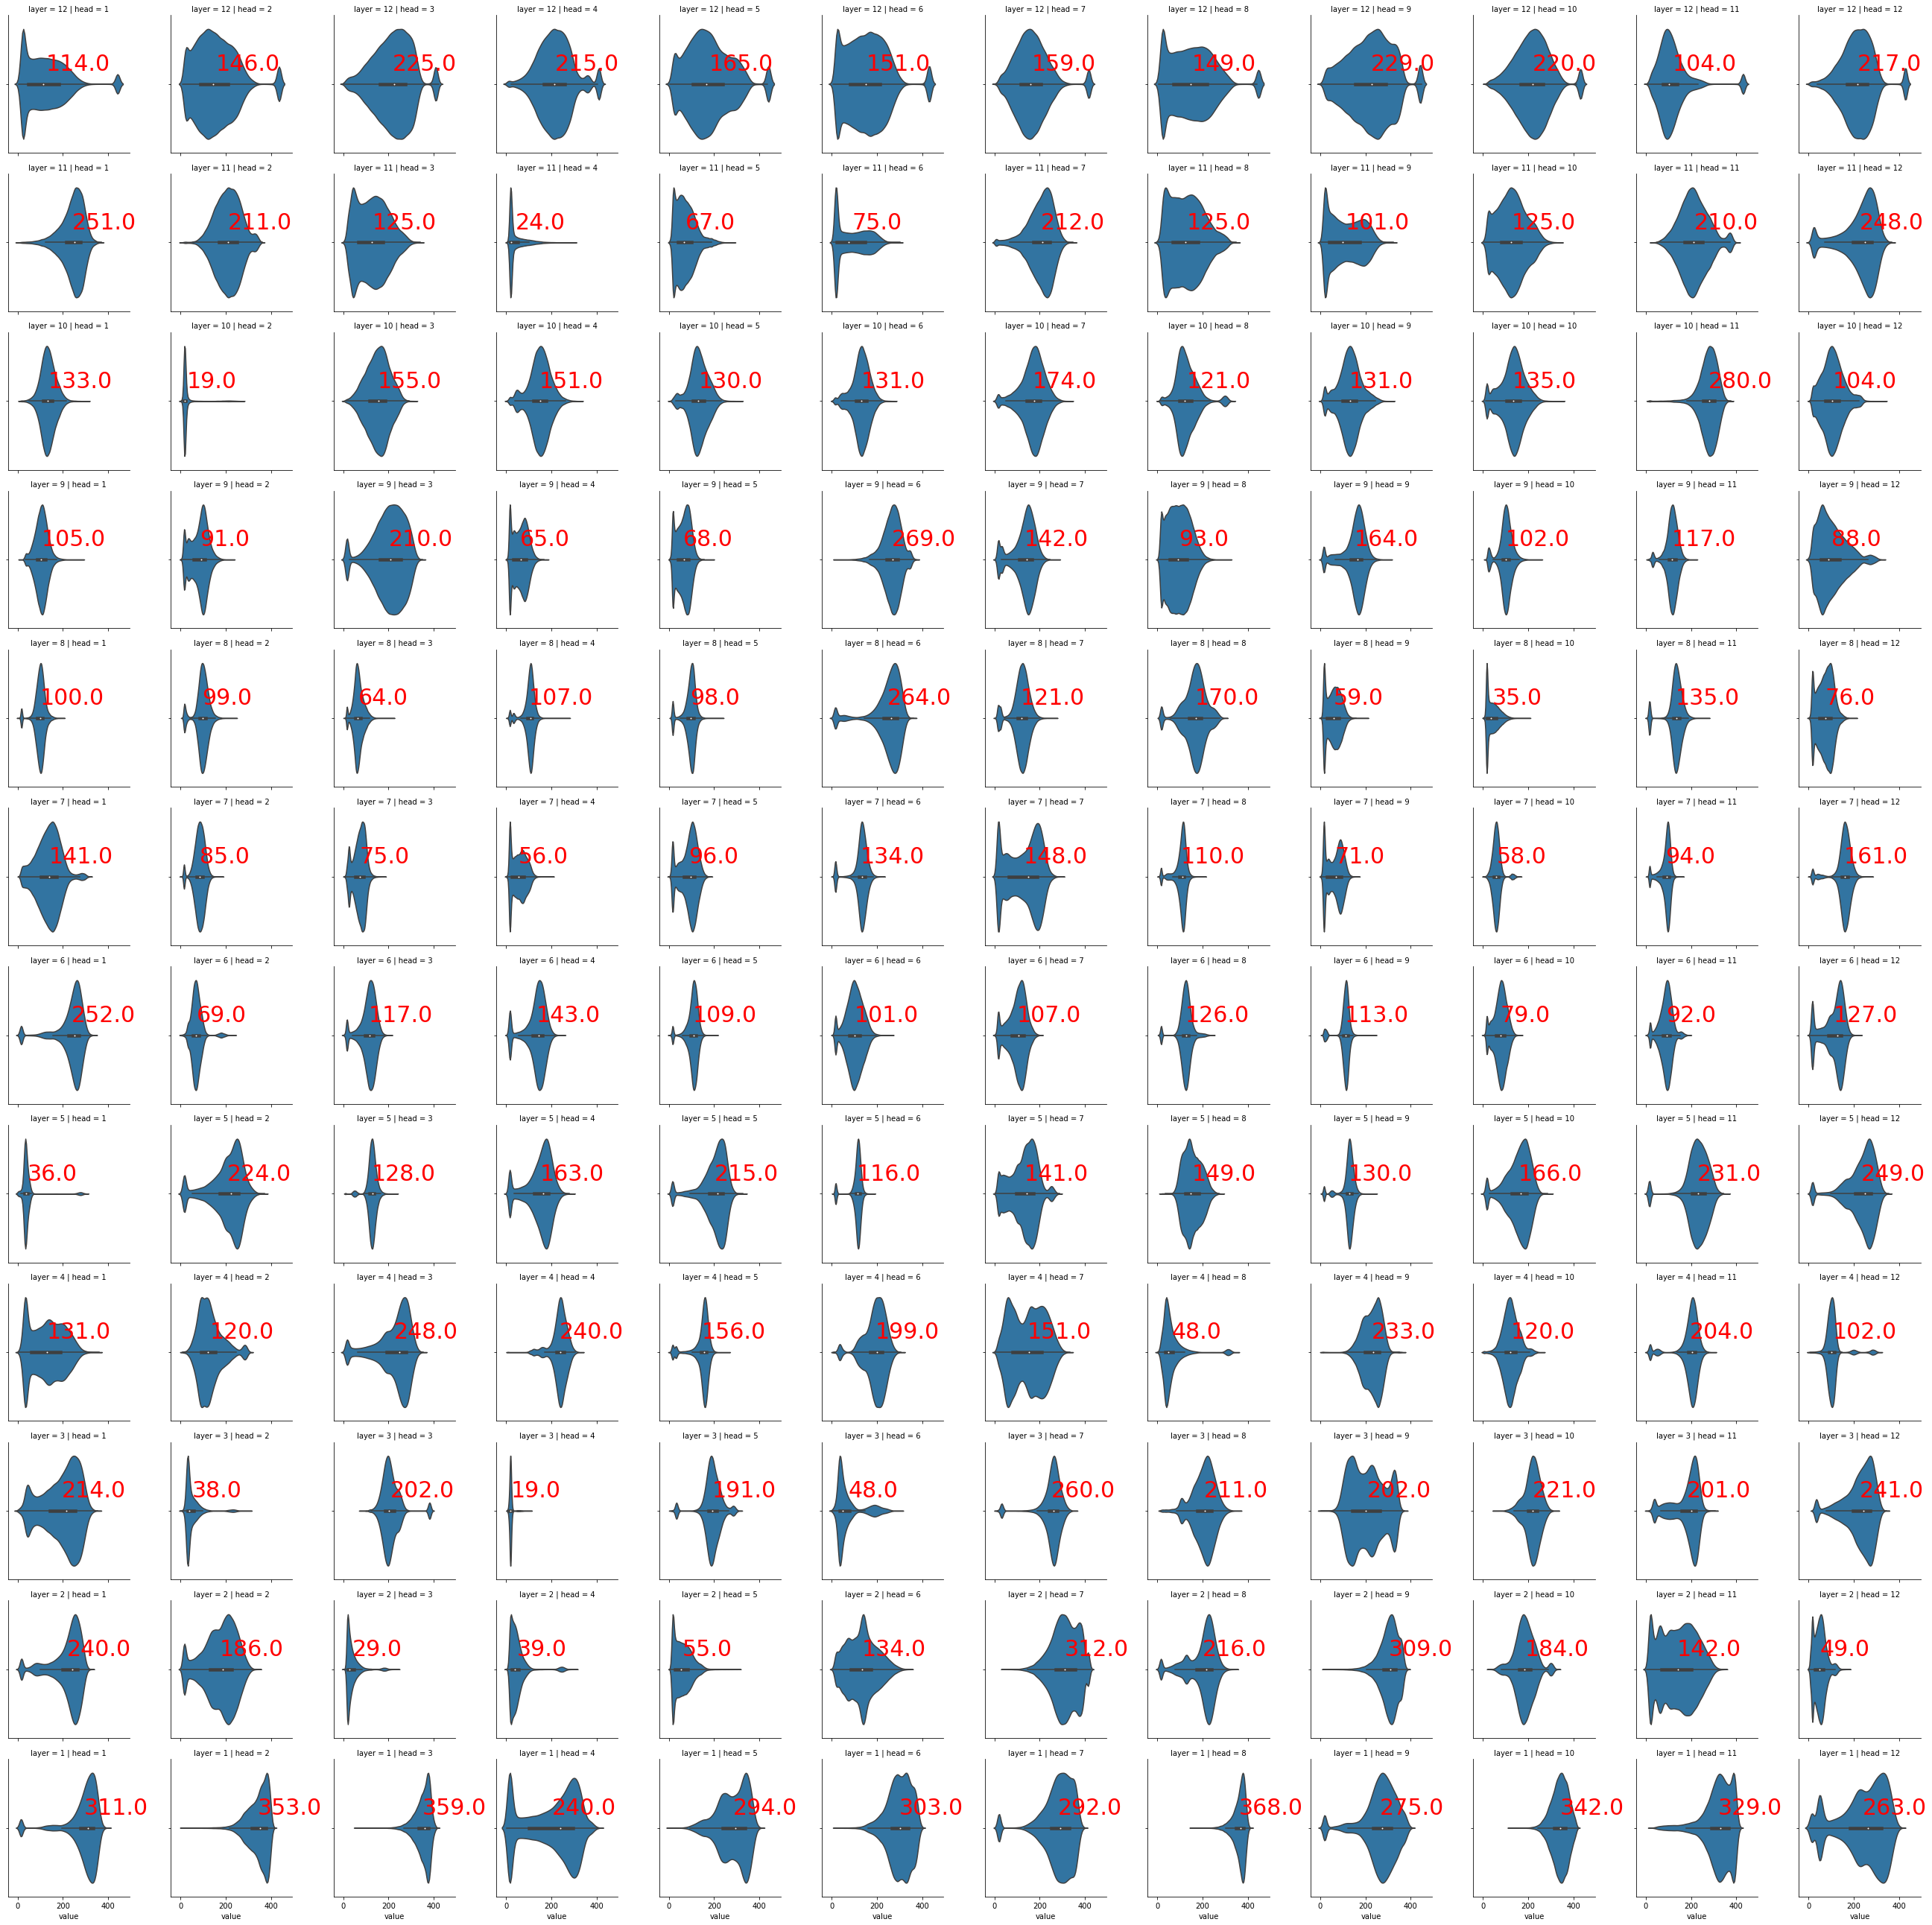

In [78]:
%%time
def make_violin(x, **kwargs):
    v = seaborn.violinplot(x=x, **kwargs)
    data = kwargs['data']
    median_k = np.median(data[x])
    mean = np.mean(data[x])
    v.text(mean, -0.1, str(median_k), fontdict=dict(color="red", fontsize=30))
    return v
g = seaborn.FacetGrid(data_sh, col="head",  row="layer", col_order=(np.arange(h) + 1), row_order=np.flip(np.arange(l) + 1))
g.map_dataframe(make_violin, "value")

### And the heads per layer sorted by the median k, like in the hopfield networks paper

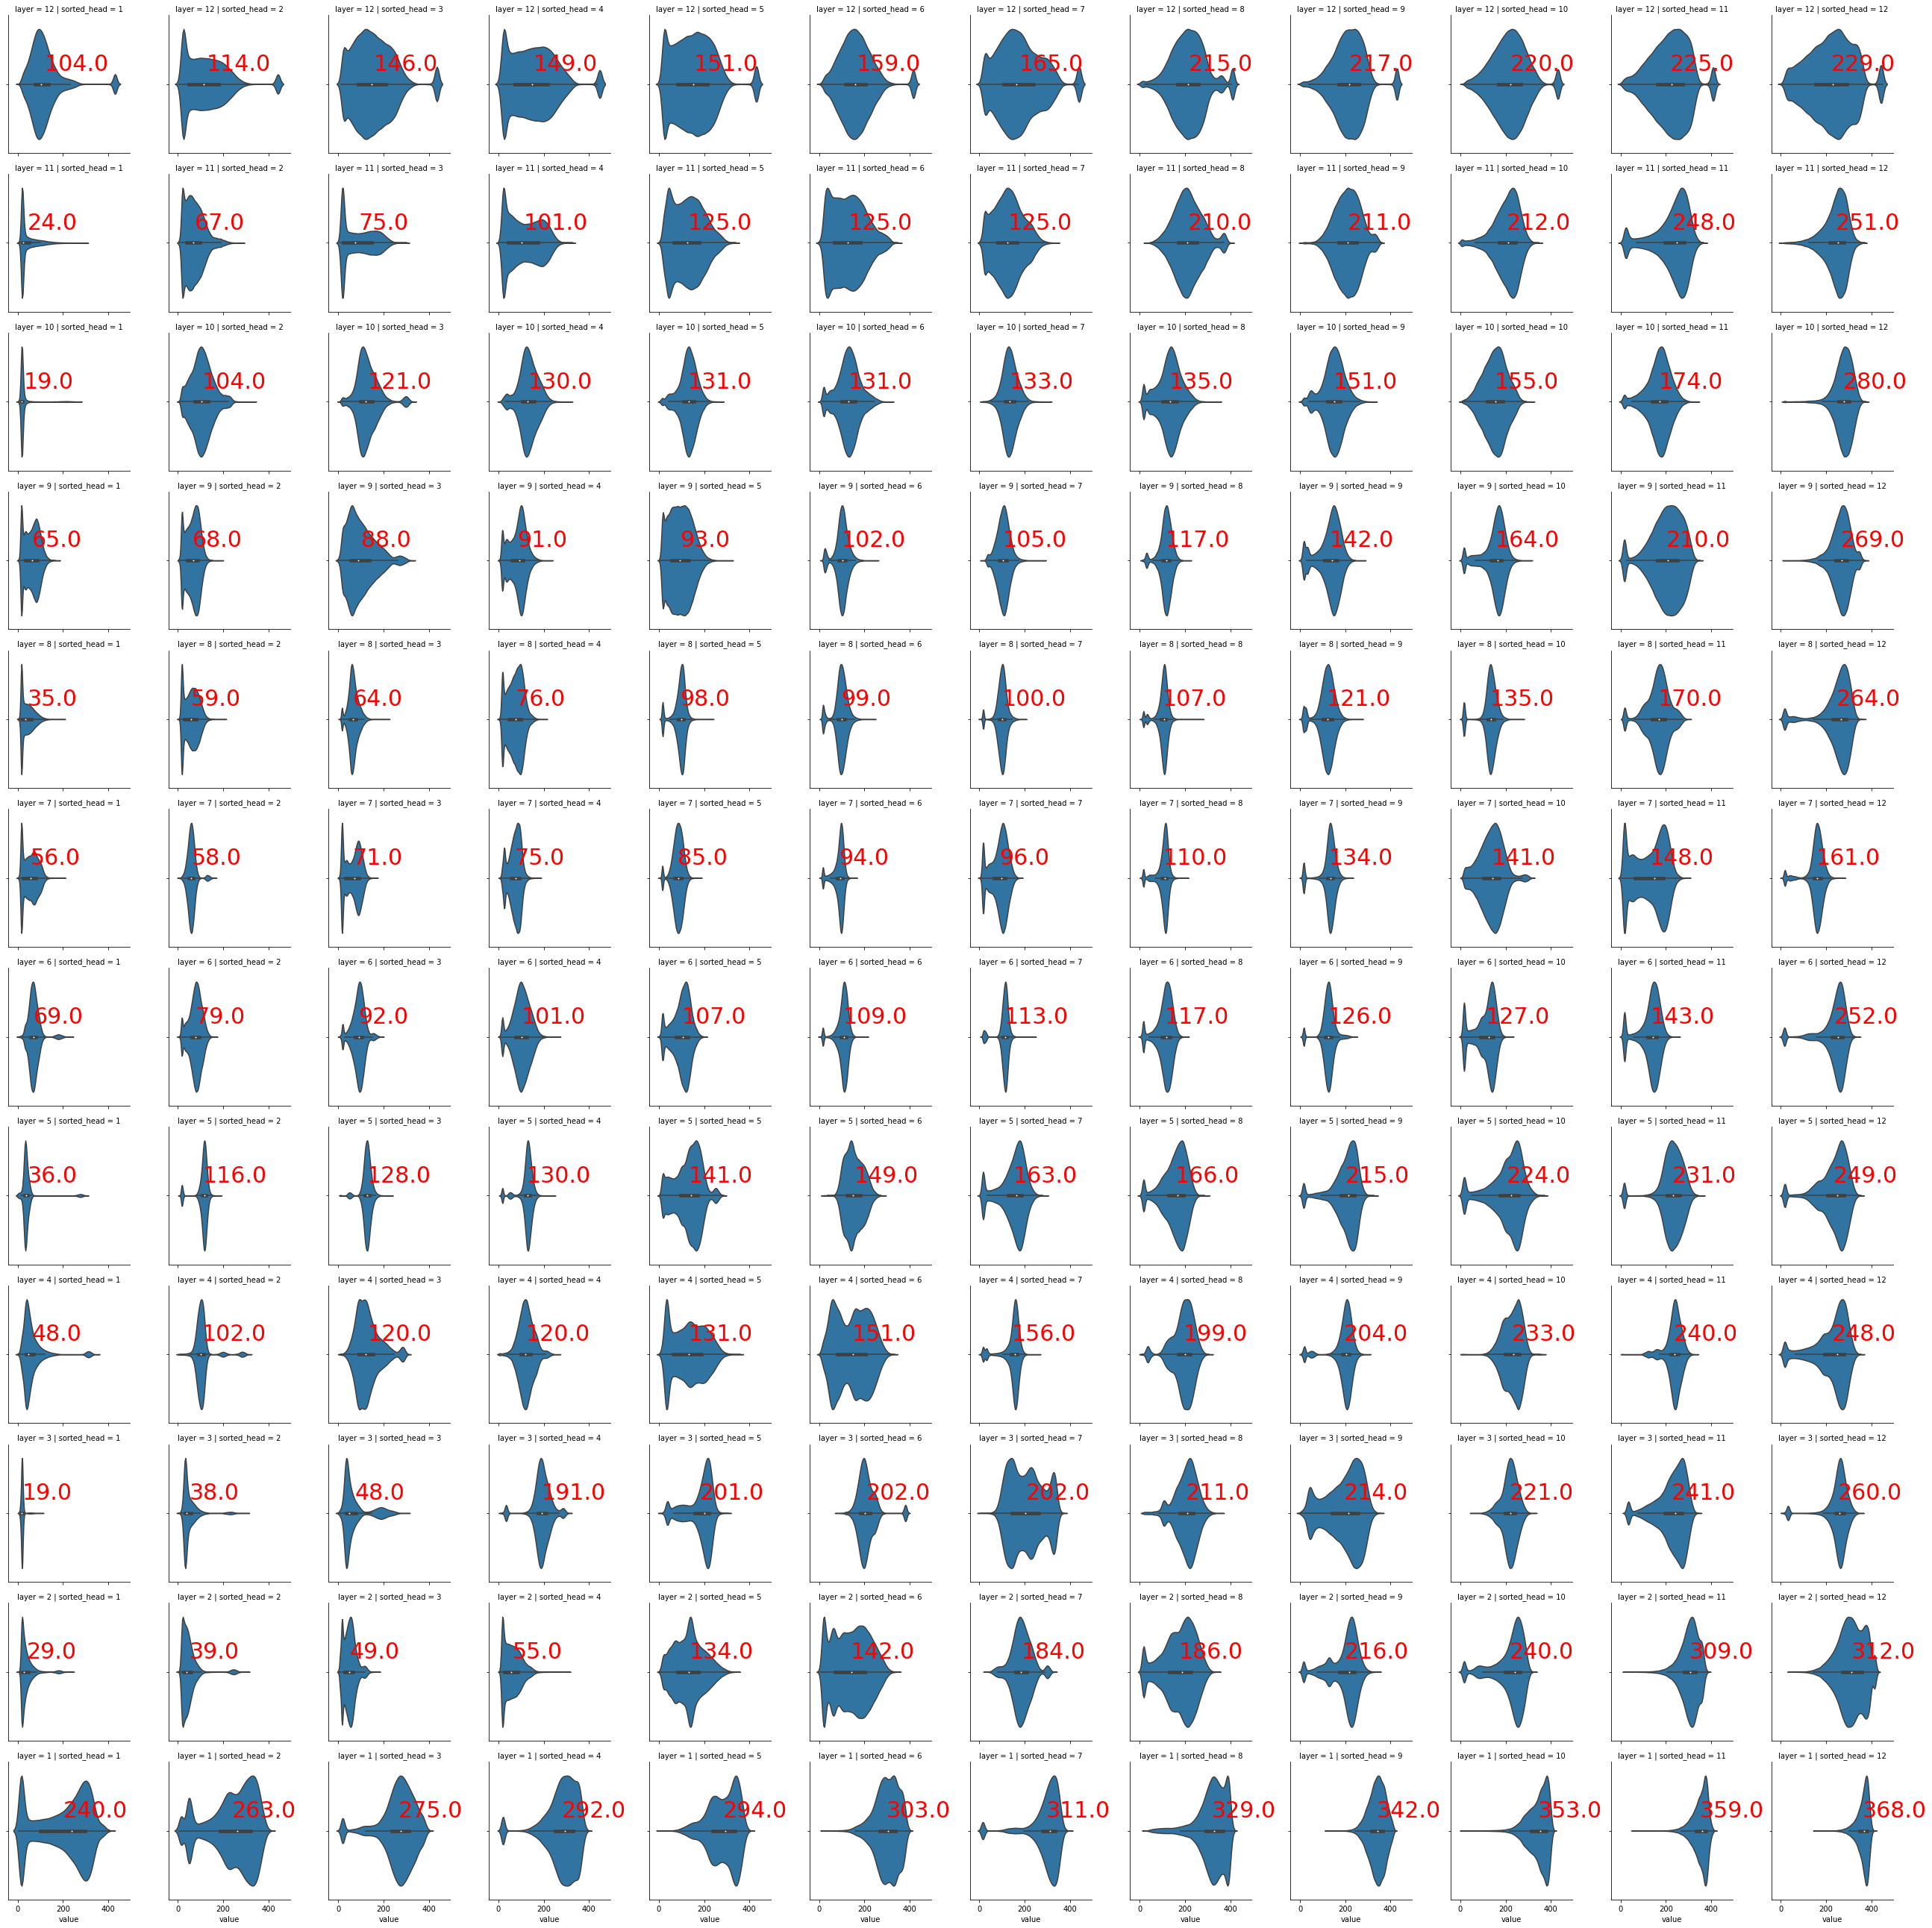

In [79]:
g = seaborn.FacetGrid(data_sh, col="sorted_head",  row="layer", col_order=(np.arange(h) + 1), row_order=np.flip(np.arange(l) + 1))
g.map_dataframe(make_violin, "value")